In [1]:
import pyNN.nest as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility import Timer
import pylab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

timer = Timer()
ts = 0.1
simulation_time = 50

#p.setup(timestep=ts, min_delay=ts, max_delay=2.0*ts) # 0.1ms 
p.setup(timestep=ts) # 0.1ms

0

# Define Neural Populations

In [2]:
n_input_neurons     = 10
n_readout_neurons   = 2
n_reservoir_neurons = 1000
exc_rate            = 0.8 # % of excitatory neurons in reservoir


n_exc = int(round(n_reservoir_neurons*exc_rate))
n_inh = n_reservoir_neurons-n_exc
print n_exc, n_inh

izh_celltype = p.native_cell_type('izhikevich')
if_celltype = p.IF_curr_exp

celltype = izh_celltype

800 200


## Input Population

In [3]:
spike_source = p.native_cell_type('poisson_generator')
#inp_pop=p.Population(n_input_neurons,spike_source,{'rate':100.0, 'origin':20, 'start':50, 'stop':100})
inp_pop=p.Population(n_input_neurons,spike_source,{'rate':10.0})

## Reservoir Populations - Excitatory and Inhibitory

In [4]:
exc_cells = p.Population(n_exc, celltype, label="Excitatory_Cells")
inh_cells = p.Population(n_inh, celltype, label="Inhibitory_Cells")

# initialize with a uniform random distributin
# use seeding for reproducability
rngseed = 98766987
parallel_safe = True
rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)

unifDistr = RandomDistribution('uniform', (-70,-65), rng=rng)
#exc_cells.initialize('v':unifDistr)
inh_cells.initialize('V_m',unifDistr)
exc_cells.initialize('V_m',unifDistr)

## Readout Neurons

In [5]:
readout_neurons = p.Population(2, celltype, label="readout_neuron")

# Define Neural Projections 

In [6]:
celltype.synapse_types

('excitatory', 'inhibitory')

## Projection from Input to Reservoir

In [7]:
inp_weight=3.
inp_delay =1

inp_weight_distr = RandomDistribution('normal', [inp_weight, 1e-3], rng=rng)

# connect each input neuron to 30% of the reservoir neurons
inp_conn = p.FixedProbabilityConnector(p_connect=0.3,weights =inp_weight_distr, delays=inp_delay)



connections = {}


connections['inp2e'] = p.Projection(inp_pop, exc_cells, inp_conn)
connections['inp2i'] = p.Projection(inp_pop, inh_cells, inp_conn)


## Projection within Reservoir

In [8]:
pconn = 0.01      # sparse connection probability

# scale the weights w.r.t. the network to keep it stable
w_exc = 0.2/np.sqrt(n_exc)      # nA
w_inh = -0.8/np.sqrt(n_inh)   # nA
delay_exc = 1      # defines how long (ms) the synapse takes for transmission
delay_inh = 1

weight_distr_exc = RandomDistribution('normal', [w_exc, 1e-3/n_exc], rng=rng)
weight_distr_inh = RandomDistribution('normal', [w_inh, 1e-3/n_inh], rng=rng)



#exc_conn = p.FixedProbabilityConnector(pconn, rng=rng)
#inh_conn = p.FixedProbabilityConnector(pconn, rng=rng)

exc_conn = p.FixedProbabilityConnector(pconn, weights=weight_distr_exc, delays=delay_exc)
inh_conn = p.FixedProbabilityConnector(pconn, weights=weight_distr_inh, delays=delay_inh)


connections['e2e'] = p.Projection(exc_cells, exc_cells, exc_conn, target='excitatory')
connections['e2i'] = p.Projection(exc_cells, inh_cells, exc_conn, target='excitatory')


# Balance Condition: Choose inhibitory weights 

Perfect column balance codition (all column sums are 0). This means, that the input to every neuron sums up to 0

In [9]:
weights_e2e = connections['e2e'].getWeights(format='array')
weights_e2i = connections['e2i'].getWeights(format='array')

np.nan_to_num(weights_e2e, copy=False)
np.nan_to_num(weights_e2i, copy=False)


e2e_column_sums = np.sum(weights_e2e, axis=0)
e2i_column_sums = np.sum(weights_e2i, axis=0)
print np.shape(e2e_column_sums)
print np.shape(e2i_column_sums)

No handlers could be found for logger "PyNN"


(800,)
(200,)


In [10]:
# i2e
import numpy.matlib
i2e_mean_weights = -e2e_column_sums/n_inh
i2e_weights = np.matlib.repmat(i2e_mean_weights,n_inh,1)
np.shape(i2e_weights)


(200, 800)

In [11]:
# i2i
i2i_mean_weights = -e2i_column_sums/n_inh
i2i_weights = np.matlib.repmat(i2i_mean_weights,n_inh,1)
np.shape(i2i_weights)


(200, 200)

In [12]:
i_e_conn = p.AllToAllConnector(weights=i2e_weights, delays=delay_inh)
i_i_conn = p.AllToAllConnector(weights=i2i_weights, delays=delay_inh)

connections['i2e'] = p.Projection(inh_cells, exc_cells, i_e_conn, target='inhibitory')
connections['i2i'] = p.Projection(inh_cells, inh_cells, i_i_conn, target='inhibitory')

In [13]:
weights_i2e = connections['i2e'].getWeights(format='array')
weights_i2i = connections['i2i'].getWeights(format='array')
np.shape(weights_e2e)
np.shape(weights_i2e)

a=np.concatenate((weights_e2e,weights_i2e), axis=0)
b=np.concatenate((weights_e2i,weights_i2i), axis=0)
weight_matrix=np.concatenate((a,b), axis=1)
print np.shape(weight_matrix)
np.nan_to_num(weight_matrix, copy=False)


(1000, 1000)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.00031823, -0.00017677, -0.00031816, ..., -0.00045962,
        -0.00017674, -0.00028282],
       [-0.00031823, -0.00017677, -0.00031816, ..., -0.00045962,
        -0.00017674, -0.00028282],
       [-0.00031823, -0.00017677, -0.00031816, ..., -0.00045962,
        -0.00017674, -0.00028282]])

In [14]:
# compute column-sums
a = np.max(np.sum(weight_matrix[:,0:159],axis=0))
print a
b = np.max(np.sum(weight_matrix[:,160:199],axis=0))
print b

3.54100429534e-16
4.03540048599e-16


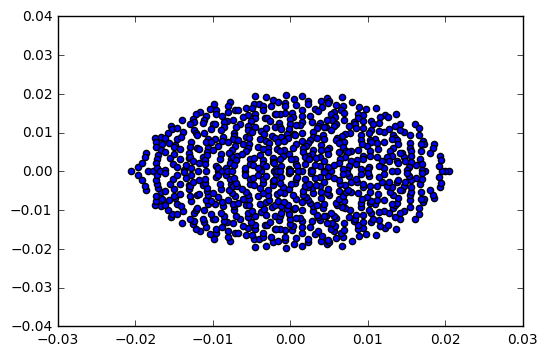

In [15]:
# complete weight matrix --> eigenvalues are more dense in the center if f>0.5

eigenvalues, eigenvectors=np.linalg.eig(weight_matrix)
plt.scatter(eigenvalues.real, eigenvalues.imag)

In [16]:
# E-E weight matrix -> eigenvalues are uniformly distributed

weights = connections['e2e'].getWeights(format='array')
np.nan_to_num(weights, copy=False)
weights

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

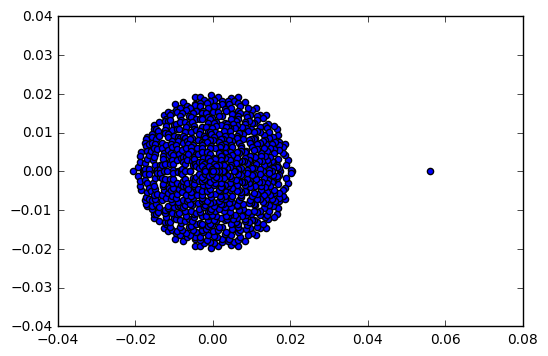

In [17]:
eigenvalues, eigenvectors=np.linalg.eig(weights)
plt.scatter(eigenvalues.real, eigenvalues.imag)
#eigenvalues

## Projection to Readout Neurons

In [18]:
rout_w_exc = 20   # nA
rout_w_inh = -80   # nA
# 20, -51

rout_conn_exc = p.AllToAllConnector(weights=rout_w_exc, delays=delay_exc)
rout_conn_inh = p.AllToAllConnector(weights=rout_w_inh, delays=delay_exc)


connections['e2rout'] = p.Projection(exc_cells, readout_neurons, rout_conn_exc, target='excitatory')
connections['i2rout'] = p.Projection(inh_cells, readout_neurons, rout_conn_inh, target='inhibitory')


## Record spikes and voltages from readout_neurons

In [19]:
readout_neurons.record()
#readout_neurons.record_v()
exc_cells.record()
inp_pop.record()

# Run the Simulation and Plot the Spikes

In [20]:
timer.reset()
p.run(simulation_time)
a= timer.elapsedTime()  # [s], ~0.11 s
print a

r_spikes = readout_neurons.getSpikes()
#r_v = readout_neurons.get_v()
exc_spikes = exc_cells.getSpikes()
inp_spikes = inp_pop.getSpikes()



0.0895009040833


In [21]:
p.end()

In [22]:
shape=np.shape(r_spikes)
print(shape)
r_spikes[0:10,:]

(626, 2)


array([[ 0. ,  2.3],
       [ 1. ,  2.3],
       [ 0. ,  2.5],
       [ 1. ,  2.5],
       [ 0. ,  2.7],
       [ 1. ,  2.7],
       [ 0. ,  2.9],
       [ 1. ,  2.9],
       [ 0. ,  3. ],
       [ 1. ,  3. ]])

In [23]:
timer.reset()
timer.elapsedTime()

3.314018249511719e-05

In [24]:
spiketrains = []
for i in range(int(r_spikes[:,0].max())+1): # for all readout neurons
    print i
    spiketrain = r_spikes[np.where(r_spikes[:,0]==i),1]
    spiketrain=np.squeeze(spiketrain)
    print np.shape(spiketrain)
    spiketrains.append(spiketrain)

0
(313,)
1
(313,)


In [25]:
len(spiketrain)

313

# TODO compute the input spike rates at the last spike time
# -> helps to calibrate the spike rate


f = lambda x: x*0.3*np.exp(2-x*0.3)
n_neurons= int(inp_spikes[:,0].max())+1

spiketrains = []
# for all readout neurons
for i in range(n_neurons): 
    spiketrain = inp_spikes[np.where(inp_spikes[:,0]==i),1]
    spiketrain=np.squeeze(spiketrain)
    spiketrains.append(spiketrain)
     # Spiketrains is a list with the spiketime-arrays for each neuron as elements

last_spike = np.max(spiketrains)
alpha_rates=np.zeros((n_neurons,))

for i, spiketrain in enumerate(spiketrains):
	for spike in spiketrain:
            # weight spike based on time
	    alpha_rates[i]+=f(last_spike-spike)
    
print alpha_rates

In [26]:
# compute the readout spike rates at the last spike time

f = lambda x: x*0.3*np.exp(2-x*0.3)
n_neurons= int(r_spikes[:,0].max())+1

spiketrains = []
# for all readout neurons
for i in range(n_neurons): 
    spiketrain = r_spikes[np.where(r_spikes[:,0]==i),1]
    spiketrain=np.squeeze(spiketrain)
    spiketrains.append(spiketrain)
     # Spiketrains is a list with the spiketime-arrays for each neuron as elements

last_spike = np.max(spiketrains)
alpha_rates=np.zeros((n_neurons,))

for i, spiketrain in enumerate(spiketrains):
	for spike in spiketrain:
            # weight spike based on time
	    alpha_rates[i]+=f(last_spike-spike)
    
print alpha_rates

[ 165.90933736  165.90933736]


In [27]:
# plot
def plot_spikes(spiketrain):
    st = [spike[1] for spike in spiketrain] # spike times
    sid = [spike[0] for spike in spiketrain]

    plt.plot(st, sid, "|")
    plt.axis([np.min(st), np.max(st), np.min(sid)-1, np.max(sid)+1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.title('Spike Plot')
    plt.xlim(xmin=0)
    plt.show()

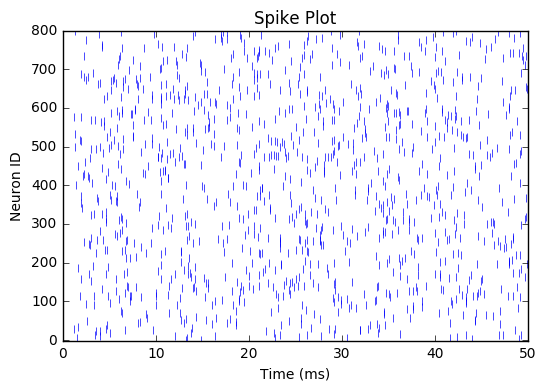

In [28]:
plot_spikes(exc_spikes)

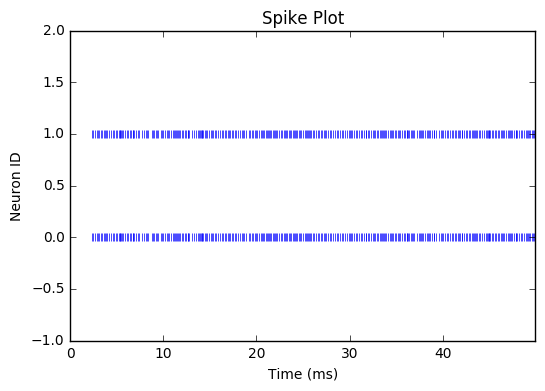

In [29]:
plot_spikes(r_spikes)

In [ ]:
# separability
# learning
# perceptron readouts